<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Positional_Trading_with_Auto_Regression_Finite_Horizon_Forecast_(Linear_Algebra).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as la
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
ticker = 'BANKBEES.NS'

ar_p = 300
ar_h = 260

num_paths = 10000
paths_to_plot = 5

In [4]:
def download_data(entity, ticker):
    print(f"Downloading {ticker}")

    data = yf.download(ticker, period="5y", interval="1d")

    if data.index.tzinfo is None:
        data.index = data.index.tz_localize('UTC')

    data.index = data.index.tz_convert('Asia/Kolkata')

    data_ = pd.DataFrame({
        'S' : data['Close'].values.reshape((-1,))
    }, index = data.index)

    entity['data'] = data_

In [5]:
def calculate_return(entity):
    data = entity['data']

    data.eval('log_S = log(S)', inplace = True)
    data['r'] = data['log_S'].diff()

In [6]:
def split_data(entity):
    entity['train'] = entity['data'].iloc[:-ar_h]
    entity['test'] = entity['data'].iloc[-ar_h:]

In [7]:
def train_feature_engg(entity):
    data = entity['train']

    features_df = data[['S', 'r']]

    features_df['x'] = (features_df['r'] - features_df['r'].mean())/features_df['r'].std()

    for idx in range(ar_p):
        features_df[f'x_m{idx + 1}'] = features_df['x'].shift(idx + 1)

    for idx in range(ar_h):
        features_df[f'x_p{idx}'] = features_df['x'].shift(-idx)


    features_df.dropna(inplace = True)

    entity['features'] = features_df

    entity['features_train_x'] = entity['features'][[f'x_m{idx + 1}' for idx in range(ar_p)]]
    entity['features_train_y'] = entity['features'][[f'x_p{idx}' for idx in range(ar_h)]]

In [8]:
def forecast_feature_engg(entity):
    data = entity['data']

    features_df = data[['S', 'r']]

    features_df['x'] = (features_df['r'] - features_df['r'].mean())/features_df['r'].std()

    for idx in range(ar_p):
        features_df[f'x_m{idx + 1}'] = features_df['x'].shift(idx + 1)

    for idx in range(ar_h):
        features_df[f'x_p{idx}'] = features_df['x'].shift(-idx)


    features_df.dropna(inplace = True)

    entity['features_forecast'] = features_df

    entity['features_forecast_x'] = entity['features_forecast'][[f'x_m{idx + 1}' for idx in range(ar_p)]]
    entity['features_forecast_y'] = entity['features_forecast'][[f'x_p{idx}' for idx in range(ar_h)]]

In [9]:
def fit_model(entity):
    delta_x = entity['features_train_x'] - entity['features_train_x'].mean()
    delta_y = entity['features_train_y'] - entity['features_train_y'].mean()

    A = np.matmul(delta_x.T, delta_x)
    b = np.matmul(delta_x.T, delta_y)
    inv_A = pd.DataFrame(la.inv(A), columns = A.columns, index = A.index)
    weights = np.matmul(inv_A, b)

    mean_x = pd.DataFrame({'Intercept' : entity['features_train_x'].mean()}).T
    mean_y = pd.DataFrame({'Intercept' : entity['features_train_y'].mean()}).T
    intercept = mean_y - np.matmul(mean_x, weights)


    residue = entity['features_train_y'] - np.matmul(entity['features_train_x'], weights)

    dof = len(entity['features_train_x']) - len(weights) - 1
    sigma_df = pd.DataFrame({'sigma' : np.sqrt((residue**2).sum()/dof)})

    entity['params'] = pd.concat([intercept, weights, sigma_df.T])

In [10]:
def fit_forecast_model(entity):
    delta_x = entity['features_forecast_x'] - entity['features_forecast_x'].mean()
    delta_y = entity['features_forecast_y'] - entity['features_forecast_y'].mean()

    A = np.matmul(delta_x.T, delta_x)
    b = np.matmul(delta_x.T, delta_y)
    inv_A = pd.DataFrame(la.inv(A), columns = A.columns, index = A.index)
    weights = np.matmul(inv_A, b)

    mean_x = pd.DataFrame({'Intercept' : entity['features_forecast_x'].mean()}).T
    mean_y = pd.DataFrame({'Intercept' : entity['features_forecast_y'].mean()}).T
    intercept = mean_y - np.matmul(mean_x, weights)


    residue = entity['features_forecast_y'] - np.matmul(entity['features_forecast_x'], weights)

    dof = len(entity['features_forecast_x']) - len(weights) - 1
    sigma_df = pd.DataFrame({'sigma' : np.sqrt((residue**2).sum()/dof)})

    entity['forecast_params'] = pd.concat([intercept, weights, sigma_df.T])

In [11]:
def test_forecast(entity):
    pred_input_df = entity['features_train_x'].iloc[-1:]

    delta_pred_x = pred_input_df - entity['features_train_x'].mean()

    cov = entity['features_train_x'].cov()
    inv_cov = pd.DataFrame(la.inv(cov), columns = cov.columns, index = cov.index)

    N = len(entity['features_train_x'])

    mean_var_coeff = (1 + delta_pred_x @ inv_cov @ delta_pred_x.T)/N
    pred_var_coeff = 1 + mean_var_coeff
    sigma_coeff = mean_var_coeff.apply(np.sqrt).iloc[0,0]

    mean = pd.concat([np.matmul(pred_input_df, entity['params'].iloc[1 :-1]) + entity['params'].iloc[0]] * num_paths)
    sigma = sigma_coeff * pd.concat([entity['params'].iloc[-1:]] * num_paths)

    dof = len(entity['features_train_x']) - len(entity['params'].iloc[:-1])

    standard_t_df = pd.DataFrame(
        data = np.random.standard_t(df = dof, size = (num_paths, ar_h)),
        columns = entity['params'].columns
    )

    mcp_index = [f'mcp_{idx + 1}' for idx in range(num_paths)]
    standard_t_df.index = mcp_index
    mean.index = mcp_index
    sigma.index = mcp_index

    forecast_output_df = mean + sigma * standard_t_df

    entity['test_forecast_x'] = forecast_output_df

    entity['test_forecast'] = entity['test_forecast_x'] * entity['train']['r'].std() + entity['train']['r'].mean()
    entity['test_forecast'].columns = entity['test'].index
    entity['test_forecast'].index = [f'paths_{idx + 1}' for idx in range(num_paths)]
    entity['test_forecast'] = entity['test_forecast'].T

    init_S_df = entity['train'].iloc[-1:][['S']]
    init_forecast_df = pd.DataFrame(np.zeros_like(entity['test_forecast'].iloc[:1]), columns = entity['test_forecast'].columns, index = init_S_df.index)
    entity['test_forecast'] = pd.concat([init_forecast_df, entity['test_forecast']])
    entity['test_forecast_price'] = init_S_df.iloc[0, 0] * entity['test_forecast'].cumsum().apply(np.exp)

    entity['test_monte_carlo_quantiles'] = entity['test_forecast_price'].quantile([0.025, 0.25, 0.50, 0.75, .975], axis = 1).T
    entity['test_monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [12]:
def forecast(entity):
    forecast_input_df = pd.DataFrame({'x' : (entity['data'].iloc[-(ar_p + 1):]['r'] - entity['data']['r'].mean())/entity['data']['r'].std()})

    for idx in range(ar_p):
        forecast_input_df[f'x_m{idx + 1}'] = forecast_input_df['x'].shift(idx + 1)

    forecast_input_df.drop('x', axis = 1, inplace = True)
    forecast_input_df.dropna(inplace = True)

    delta_pred_x = forecast_input_df - entity['features_forecast_x'].mean()

    cov = entity['features_forecast_x'].cov()
    inv_cov = pd.DataFrame(la.inv(cov), columns = cov.columns, index = cov.index)

    N = len(entity['features_forecast_x'])

    mean_var_coeff = (1 + delta_pred_x @ inv_cov @ delta_pred_x.T)/N
    pred_var_coeff = 1 + mean_var_coeff
    sigma_coeff = mean_var_coeff.apply(np.sqrt).iloc[0,0]

    mean = pd.concat([np.matmul(entity['features_forecast_x'].iloc[-1:], entity['forecast_params'].iloc[1 :-1]) + entity['forecast_params'].iloc[0]] * num_paths)
    sigma = sigma_coeff * pd.concat([entity['params'].iloc[-1:]] * num_paths)

    dof = len(entity['features_forecast_x']) - len(entity['forecast_params'].iloc[:-1])

    standard_t_df = pd.DataFrame(
        data = np.random.standard_t(df = dof, size = (num_paths, ar_h)),
        columns = entity['forecast_params'].columns
    )

    mcp_index = [f'mcp_{idx + 1}' for idx in range(num_paths)]
    standard_t_df.index = mcp_index
    mean.index = mcp_index
    sigma.index = mcp_index

    forecast_output_df = mean + sigma * standard_t_df

    entity['forecast_x'] = forecast_output_df


    entity['forecast'] = entity['forecast_x'] * entity['data']['r'].std() + entity['data']['r'].mean()
    entity['forecast'].index = [f'paths_{idx + 1}' for idx in range(num_paths)]
    entity['forecast'] = entity['forecast'].T

    init_S_df = entity['data'].iloc[-1:][['S']]
    init_forecast_df = pd.DataFrame(np.zeros_like(entity['forecast'].iloc[:1]), columns = entity['forecast'].columns, index = init_S_df.index)
    entity['forecast'] = pd.concat([init_forecast_df, entity['forecast']])

    entity['forecast'].index = pd.date_range(start=init_S_df.index[0], periods = len(entity['forecast']), freq='B')
    entity['forecast_price'] = init_S_df.iloc[0, 0] * entity['forecast'].cumsum().apply(np.exp)

    entity['monte_carlo_quantiles'] = entity['forecast_price'].quantile([0.025, 0.25, 0.50, 0.75, .975], axis = 1).T
    entity['monte_carlo_quantiles'].columns = ['low_ci', 'quart_1st', 'median', 'quart_3rd', 'high_ci']

In [13]:
def plot_test(entity):
    selected_paths = np.random.choice(entity['test_forecast_price'].columns, paths_to_plot, replace=False)

    plt.rcParams.update({
        "font.size": 14,  # General font size
        "axes.labelsize": 16,  # X and Y axis labels
        "xtick.labelsize": 12,  # X-axis tick labels
        "ytick.labelsize": 12,  # Y-axis tick labels
        "legend.fontsize": 14  # Legend text size
    })

    plt.figure(figsize=(15, 10))
    sns.lineplot(x = 'Date', y = 'S', data = entity['data'].iloc[-(ar_p + ar_h):].reset_index(), color = 'black')

    for p in selected_paths:
        sns.lineplot(x = 'Date', y = p, data = entity['test_forecast_price'].reset_index())

    plt.fill_between(entity['test_monte_carlo_quantiles'].index, entity['test_monte_carlo_quantiles']['low_ci'], entity['test_monte_carlo_quantiles']['high_ci'], color = 'grey', alpha = 0.5)
    plt.axhline(entity['test_monte_carlo_quantiles']['low_ci'].min(), linestyle = '--', color = 'black')
    plt.axhline(entity['test_monte_carlo_quantiles']['high_ci'].max(), linestyle = '--', color = 'black')
    plt.axvline(entity['test_monte_carlo_quantiles'].index[0], linestyle = '--', color = 'black')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Monte Carlo Test for {ticker}')
    _ = plt.xticks(rotation=90)

    plt.savefig(f"test_{ticker}.jpg", format="jpg")
    plt.show()
    plt.close()  # Close the figure to avoid overlap

In [14]:
def plot_forecast(entity):
    selected_paths = np.random.choice(entity['forecast_price'].columns, paths_to_plot, replace=False)

    plt.rcParams.update({
        "font.size": 14,  # General font size
        "axes.labelsize": 16,  # X and Y axis labels
        "xtick.labelsize": 12,  # X-axis tick labels
        "ytick.labelsize": 12,  # Y-axis tick labels
        "legend.fontsize": 14  # Legend text size
    })

    plt.figure(figsize=(15, 10))
    sns.lineplot(x = 'Date', y = 'S', data = entity['data'].iloc[-ar_p:].reset_index(), color = 'black')

    for p in selected_paths:
        sns.lineplot(x = 'index', y = p, data = entity['forecast_price'].reset_index())

    plt.fill_between(entity['monte_carlo_quantiles'].index, entity['monte_carlo_quantiles']['low_ci'], entity['monte_carlo_quantiles']['high_ci'], color = 'grey', alpha = 0.5)
    plt.axhline(entity['monte_carlo_quantiles']['low_ci'].min(), linestyle = '--', color = 'black')
    plt.axhline(entity['monte_carlo_quantiles']['high_ci'].max(), linestyle = '--', color = 'black')
    plt.axvline(entity['monte_carlo_quantiles'].index[0], linestyle = '--', color = 'black')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'Monte Carlo Forecast for {ticker}')
    _ = plt.xticks(rotation=90)

    plt.savefig(f"forecast_{ticker}.jpg", format="jpg")
    plt.show()
    plt.close()  # Close the figure to avoid overlap

In [15]:
def display_result(entity):
    print('Long Risk Level for ' , str(entity['monte_carlo_quantiles'].index[-1]), ' is ', entity['monte_carlo_quantiles']['low_ci'].min(),
          'estimated on ', str(entity['monte_carlo_quantiles'].index[0]))

    print('Short Risk Level for ' , str(entity['monte_carlo_quantiles'].index[-1]), ' is ', entity['monte_carlo_quantiles']['high_ci'].max(),
          'estimated on ', str(entity['monte_carlo_quantiles'].index[0]))

    print('Current Price on ', str(entity['data'].index[-1]), ' is ', entity['data'].iloc[-1]['S'])

In [16]:
def main(ticker):
    entity = {}
    download_data(entity, ticker)
    calculate_return(entity)
    split_data(entity)
    train_feature_engg(entity)
    forecast_feature_engg(entity)
    fit_model(entity)
    fit_forecast_model(entity)
    test_forecast(entity)
    forecast(entity)
    plot_test(entity)
    plot_forecast(entity)
    display(entity['params'])
    display_result(entity)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


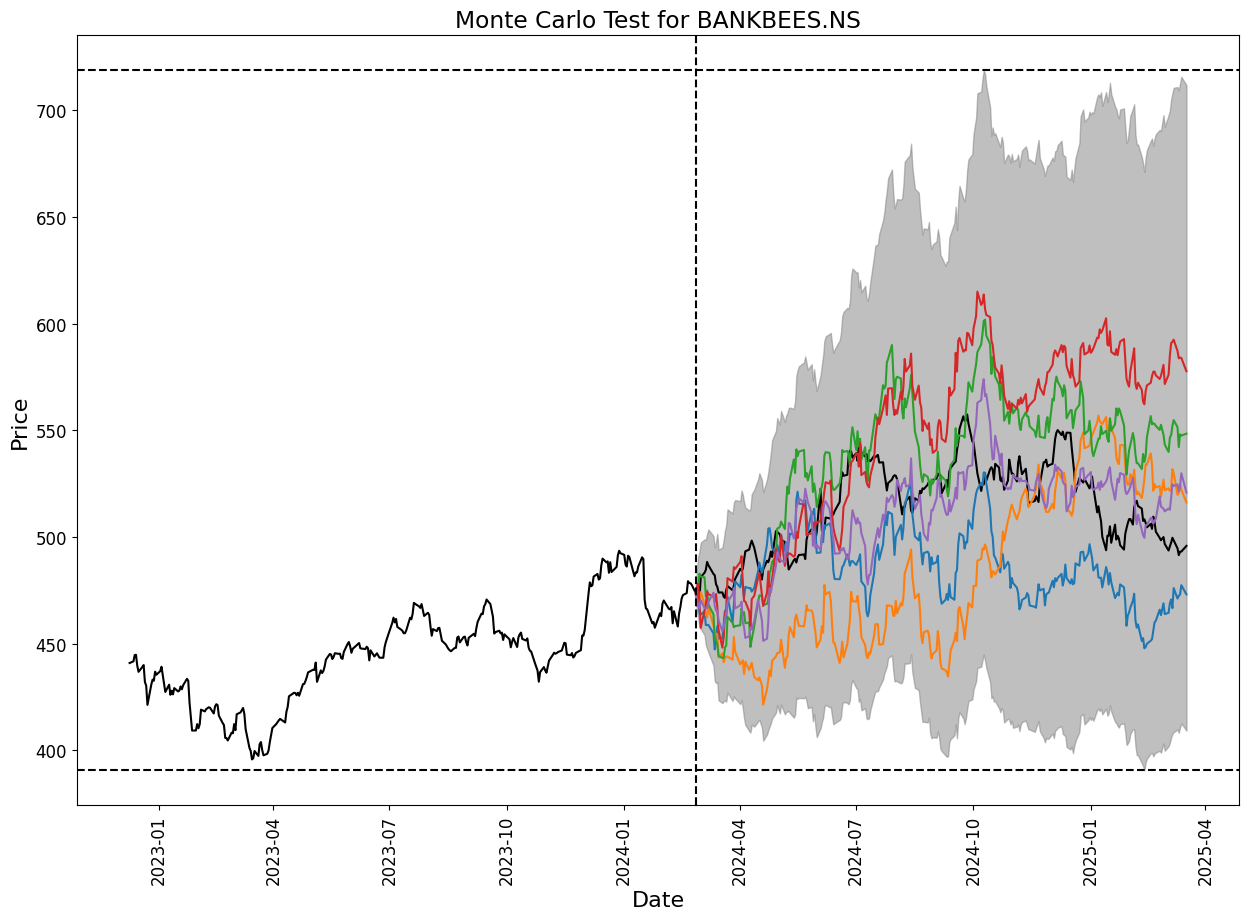

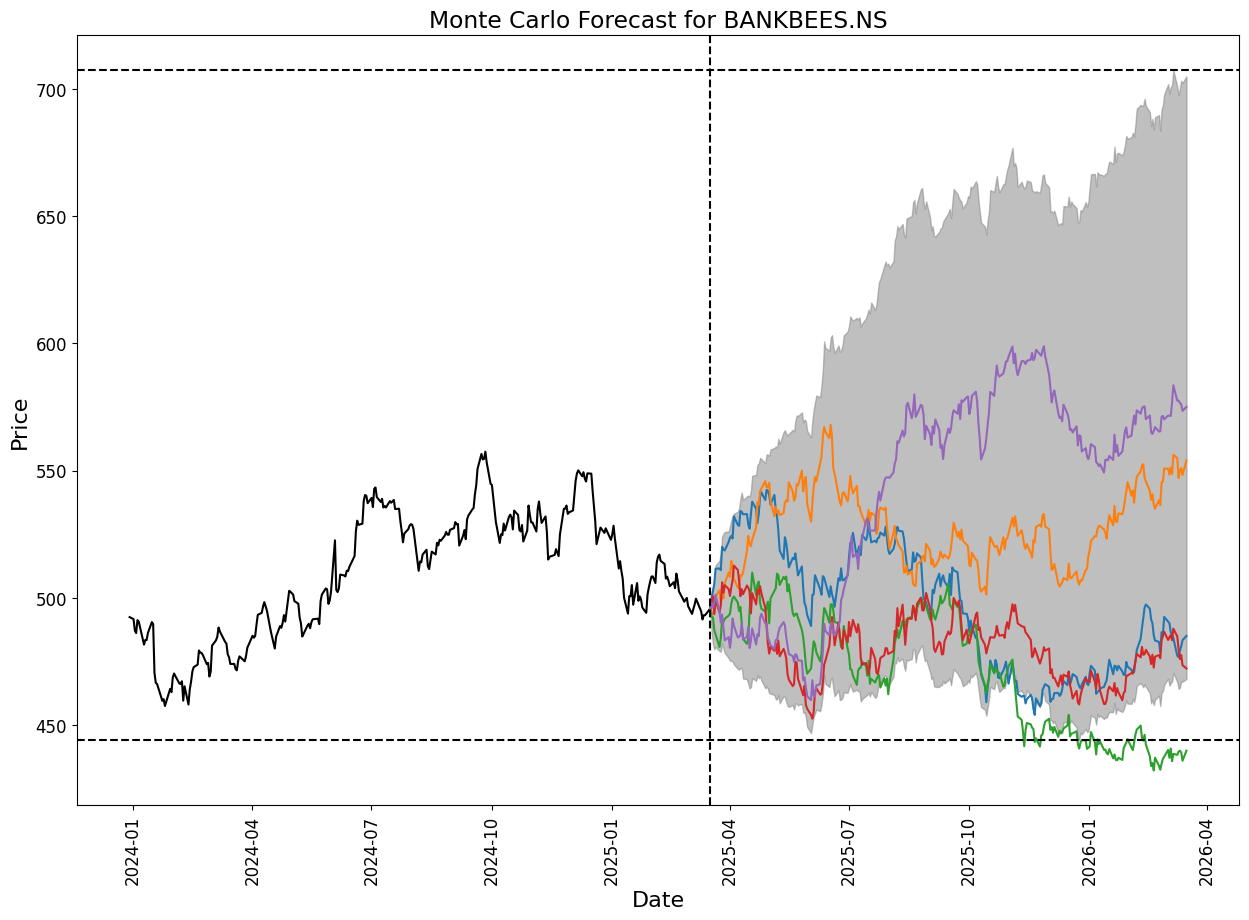

,x_p0,x_p1,x_p2,x_p3,x_p4,x_p5,x_p6,x_p7,x_p8,x_p9,...,x_p250,x_p251,x_p252,x_p253,x_p254,x_p255,x_p256,x_p257,x_p258,x_p259
Intercept,-0.035473,-0.036001,-0.030016,-0.032999,-0.029410,-0.033300,-0.036163,-0.030156,-0.029497,-0.026012,...,-0.004485,-0.005066,0.001279,0.002374,0.007305,0.014628,0.021910,0.019495,0.011746,0.017553
x_m1,0.141013,0.014993,0.065758,0.080856,0.075390,0.027162,-0.121433,0.010672,-0.016359,-0.118700,...,0.070840,-0.064080,0.107402,-0.047345,0.078484,0.021483,-0.092713,0.030018,-0.039216,-0.060551
x_m2,-0.014616,0.061792,0.071259,0.062603,0.022363,-0.126472,0.016458,-0.012637,-0.119939,0.087440,...,-0.078707,0.112372,-0.068150,0.080694,0.004798,-0.092421,0.047026,-0.030651,-0.045350,-0.005620
x_m3,0.064776,0.069912,0.063551,0.021254,-0.126685,0.020252,-0.011080,-0.118715,0.087268,0.021255,...,0.114688,-0.068633,0.081037,0.003720,-0.091183,0.043405,-0.032593,-0.047485,-0.011441,0.074232
x_m4,0.063241,0.056472,0.017550,-0.139319,0.011701,-0.005721,-0.102055,0.085368,0.021927,-0.080388,...,-0.070592,0.084830,-0.006131,-0.089069,0.033944,-0.046999,-0.040169,-0.018218,0.061517,0.033826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x_m297,-0.007726,-0.000609,0.069932,0.011583,-0.065010,-0.018242,-0.008965,-0.035447,0.036548,0.042977,...,0.014165,-0.046588,0.049363,-0.048312,-0.025510,0.000782,-0.063978,-0.065418,-0.018013,0.018235
x_m298,0.002185,0.062635,0.013463,-0.071605,-0.020449,-0.007127,-0.030496,0.029000,0.041639,-0.068215,...,-0.045549,0.046004,-0.048821,-0.026389,-0.009336,-0.076948,-0.060424,-0.017707,0.005361,-0.000334
x_m299,0.065898,0.020744,-0.072919,-0.014073,-0.008092,-0.029912,0.030740,0.046918,-0.065237,0.082087,...,0.048263,-0.043705,-0.023137,-0.006729,-0.063972,-0.051307,-0.025226,-0.002288,0.004627,0.038757
x_m300,0.006096,-0.065578,-0.020788,-0.006506,-0.030189,0.031923,0.046449,-0.049398,0.083687,-0.023698,...,-0.048890,-0.015256,-0.016345,-0.062682,-0.041464,-0.011078,-0.004732,0.003501,0.056411,0.020586


Long Risk Level for  2026-03-16 05:30:00+05:30  is  444.1531562520859 estimated on  2025-03-17 05:30:00+05:30
Short Risk Level for  2026-03-16 05:30:00+05:30  is  707.2504346740903 estimated on  2025-03-17 05:30:00+05:30
Current Price on  2025-03-17 05:30:00+05:30  is  495.8599853515625


In [17]:
main(ticker)